In [64]:
## 📍 Evaluation Results

###This section shows the model's accuracy, AUC, and other metrics on the test set.


In [65]:
#Load and preprocess data

import pandas as pd

df = pd.read_csv("data/sleep_health_and_lifestyle_dataset.csv")
df.dropna(inplace=True)
df["Sleep Efficiency"] = (df["Sleep Duration"] / 8) * 100

df["Heart Disease"] = (
    (df["BMI Category"].isin(["Obese", "Overweight"])) &
    (df["Stress Level"] >= 7) &
    (df["Sleep Disorder"].isin(["Sleep Apnea", "Insomnia"])) &
    (df["Heart Rate"] >= 80)
).astype(int)

In [66]:
#Set up features and model pipeline

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric),
    ("cat", encoder, categorical)
])

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

model = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(eval_metric="logloss", random_state=42))
])

In [67]:
#Train/test split and fit

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Sleep Duration',
                                                   'Quality of Sleep',
                                                   'Stress Level',
                                                   'Physical Activity Level',
                                                   'Heart Rate']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Occupation',
                                                   'Sleep Disorder',
                                                   'BMI Category'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [68]:
#Evaluate the model

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0
ROC-AUC: 0.9999999999999999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         1

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

[[30  0]
 [ 0  1]]


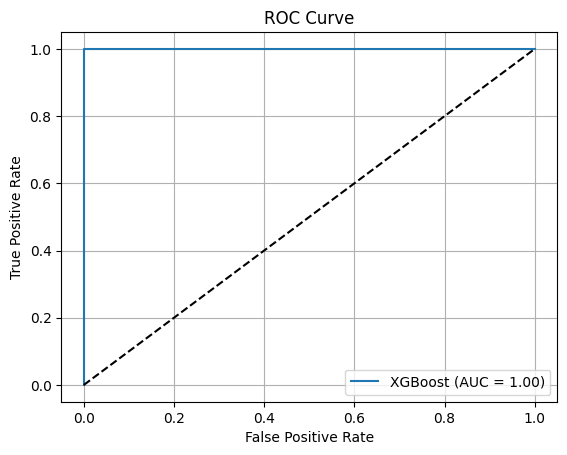

In [69]:
#Plot ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='XGBoost (AUC = %.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Cross-validation

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print("Cross-validation AUC scores:", cv_scores)
print("Mean AUC: %.3f ± %.3f" % (cv_scores.mean(), cv_scores.std()))



Cross-validation AUC scores: [1. 1. 1. 1. 1.]
Mean AUC: 1.000 ± 0.000


In [71]:
print(df["Heart Disease"].value_counts())


Heart Disease
0    148
1      7
Name: count, dtype: int64


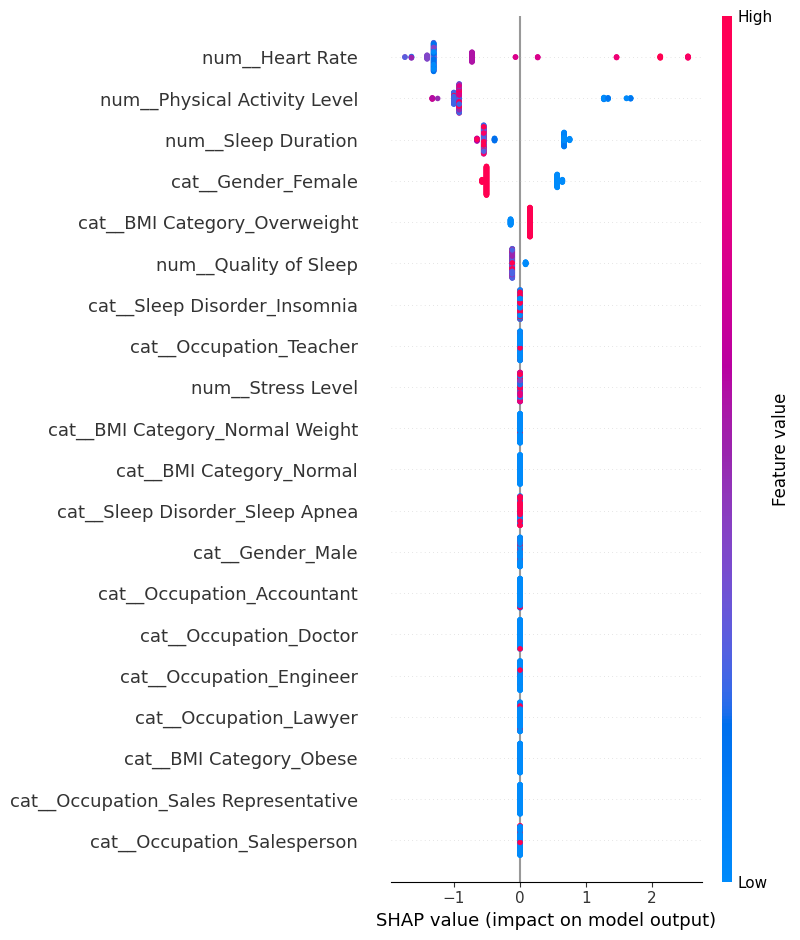

In [72]:
import shap

# Extract trained XGBoost model from pipeline
xgb_model = model.named_steps["clf"]
X_transformed = model.named_steps["prep"].transform(X)

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_transformed)

# SHAP summary plot
shap.summary_plot(shap_values, X_transformed, feature_names=model.named_steps["prep"].get_feature_names_out())


Logistic Regression Accuracy: 1.0
Logistic Regression ROC-AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         1

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



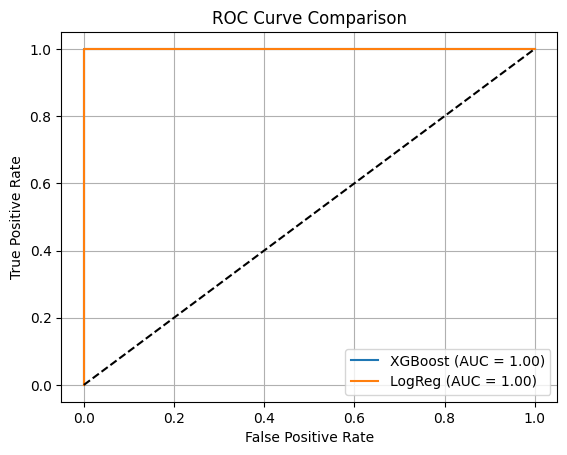

In [73]:
#Fit and Evaluate Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Build new pipeline with Logistic Regression
log_model = Pipeline([
    ("prep", preprocessor),  # Reuse same preprocessor
    ("clf", LogisticRegression(max_iter=1000))
])

# Fit and evaluate
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, y_proba_log))
print(classification_report(y_test, y_pred_log))

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba)
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)

plt.plot(fpr_xgb, tpr_xgb, label="XGBoost (AUC = %.2f)" % roc_auc_score(y_test, y_proba))
plt.plot(fpr_log, tpr_log, label="LogReg (AUC = %.2f)" % roc_auc_score(y_test, y_proba_log))
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()




In [74]:
#Apply SMOTE

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

# Preprocess training data before applying SMOTE
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Train XGBoost on SMOTE data
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred = model.predict(X_test_processed)
y_proba = model.predict_proba(X_test_processed)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         1

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

ROC-AUC Score: 0.9999999999999999


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
